In [130]:
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from scipy.optimize import minimize
import networkx as nx
from scipy import sparse

In [134]:
H = np.array([[1,1,0],
              [0,1,1]])

hx1 = sparse.kron(H, np.eye(H.shape[1], dtype=bool))
hx2 = sparse.kron(np.eye(H.shape[0], dtype=bool), H.T)
Hx = sparse.csr_matrix(sparse.hstack([hx1, hx2]))

hz1 = sparse.kron(np.eye(H.shape[1], dtype=bool), H)
hz2 = sparse.kron(H.T, np.eye(H.shape[0], dtype=bool))
Hz = sparse.csr_matrix(sparse.hstack([hz1, hz2]))

H = sparse.csr_matrix(sparse.vstack([Hx, Hz]))
print(H.toarray())

n = H.shape[1]
m = H.shape[0]

G = nx.Graph()
G.add_nodes_from(np.arange(n))

for i in range(m):
    checks = H[i].indices
    for pair in itertools.combinations(checks, 2):
        G.add_edge(pair[0], pair[1])
len(G.edges)

[[1 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 1 0 0 0 0 1 1 0 0]
 [0 0 1 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 1 0 0 0 1 1]
 [0 0 0 0 0 1 0 0 1 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 1 0 0 0 0 1 0 1 0]
 [0 0 0 0 1 1 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 1]]


45

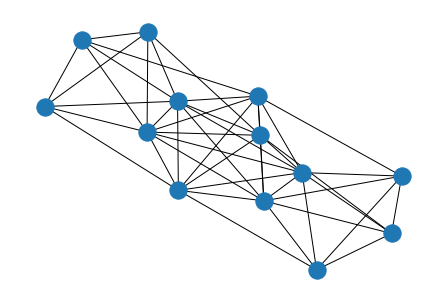

In [135]:
nx.draw(G, pos=nx.spring_layout(G))

In [144]:
for nbr in G.neighbors(0):
    print(nbr)

3
9
10
1
2


In [2]:
def manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

class Vertex:
    def __init__(self, i, x, y, neighbors):
        self.i = i
        self.x = x
        self.y = y
        self.pos = (x,y)
        self.nbrs = neighbors

    def nbrMedX(self):
        return np.median([nbr.x for nbr in self.nbrs])
    
    def nbrMedY(self):
        return np.median([nbr.y for nbr in self.nbrs])
    
    def tot_edge_len(self, p):
        return sum([manhattan(p, (nbr.x, nbr.y)) for nbr in self.nbrs])

In [120]:
n = 25

def grid_graph(n):
    grid_graph = [Vertex(i, -1,-1,[]) for i in range(n)]

    n = int(np.sqrt(n))
    edge_list = []

    for i in range(n**2):
        nbrs = []

        if (i < n**2 - n):
            nbrs.append(grid_graph[i+n])
            edge_list.append((i, i+n))
        if (i >= n):
            nbrs.append(grid_graph[i-n])
            edge_list.append((i, i-n))
        if ((i+1) % n != 0):
            nbrs.append(grid_graph[i+1])
            edge_list.append((i, i+1))
        if (i % n != 0):
            nbrs.append(grid_graph[i-1])
            edge_list.append((i, i-1))

        grid_graph[i].nbrs = nbrs

    edge_set = [v for k, v in enumerate(edge_list) if v[::-1] not in edge_list[:k]]
    return edge_set, grid_graph

edges, gg = grid_graph(n)

In [121]:
def print_graph(n, gg):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))

    lines = []
    for i in range(n):
        v = gg[i]
        for nbr in v.nbrs:
            lines.append([(v.x, v.y), (nbr.x, nbr.y)])

    xs = [gg[i].x for i in range(n)]
    ys = [gg[i].y for i in range(n)]

    pts = itertools.product(np.arange(max(xs)+1), np.arange(max(ys)+1))

    plt.scatter(*zip(*pts), s=7, c='k')
    plt.scatter(xs, ys, s=50, c='r')

    lc = mc.LineCollection(lines, colors='k', linewidth=1)
    ax.add_collection(lc)
    # ax.axis('off')
    plt.show()

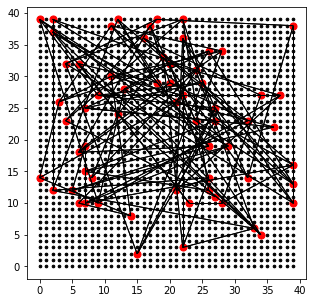

In [126]:
pos = np.array([[{'x':i,'y':j} for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))]).flatten()
grid = np.array([[None for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

initial_pos = random.sample(list(pos), n)
for i in range(n):
    gg[i].x = initial_pos[i]['x']
    gg[i].y = initial_pos[i]['y']
    grid[gg[i].x][gg[i].y] = gg[i]

print_graph(n, gg)

In [127]:
def find_nearest_available(x, y):
    n = len(grid[0])
    visited = np.zeros((n,n))

    queue = [(x, y)]
    for _ in range(n**2):
        x, y = queue.pop(0)
        
        if (not grid[x][y]):
            return (x, y)
        
        pot_nbrs = [(x, y+1), (x, y-1), (x+1, y), (x-1, y)]
        for nbr in pot_nbrs:
            new_x, new_y = nbr
            if ((0 <= new_x < n) and (0 <= new_y < n)):
                if (not visited[new_x][new_y]):
                    queue.append(nbr)
                    visited[new_x][new_y] = True


def points_with_manhattan_distance(p, d):
    n = len(grid[0])
    result = []
    for i in range(-d, d+1):
        for j in range(-d, d+1):
            new_x, new_y = (p[0]+i, p[1]+j)
            if ((manhattan(p, (new_x, new_y)) <= d)
                and (0 <= new_x < n) and (0 <= new_y < n) and (not grid[new_x][new_y])):
                result.append((new_x, new_y))
    return result


def swap_nodes(p):
    print(p)
    n = len(grid[0])
    x, y = p
    v1 = grid[x][y]
    pot_nbrs = [(x, y+1), (x, y-1), (x+1, y), (x-1, y)]
    for nbr in pot_nbrs:
        new_x, new_y = nbr
        if ((0 <= new_x < n) and (0 <= new_y < n) and (grid[new_x][new_y])):
            v2 = grid[new_x][new_y]

            if (v1.tot_edge_len(p) + v2.tot_edge_len(nbr) > v1.tot_edge_len(nbr) + v2.tot_edge_len(p)):
                v1.x = new_x
                v1.y = new_y
                v2.x = x
                v2.y = y
                grid[x][y] = v2
                grid[new_x][new_y] = v1

def compact(dir, gamma):
    def S(dir):
        edges = []
        for i in range(len(grid[0])):
            if (dir): # horizontal
                nodes = np.where(grid[:,i])[0]
                for j in range(len(nodes)-1):
                    edges.append((grid[nodes[j]][i].i, grid[nodes[j+1]][i].i))
            else: # vertical
                nodes = np.where(grid[i])[0]
                for j in range(len(nodes)-1):
                    edges.append((grid[i][nodes[j]].i, grid[i][nodes[j+1]].i))
        return edges
    
    def fun(x):
        # x is a list of x (y) coordinates of the nodes
        return sum([(x[edge[0]] - x[edge[1]])**2 for edge in edges]) #maybe abs value
    
    x = [v.x for v in gg] if dir else [v.y for v in gg]
    vis_edges = S(dir)

    res = minimize(fun, x0=x, method="SLSQP", 
                   constraints=[{'type': 'ineq', 'fun': lambda x, e=e: x[e[1]] - x[e[0]] - gamma} for e in vis_edges],
                   bounds=[(0, len(grid[0])-1) for _ in range(len(x))])

    for i, p in enumerate((res.x).astype(int)):
        v = gg[i]
        if (dir):
            v.x = p
        else:
            v.y = p       

In [128]:
iters = int(90*np.sqrt(n))
T = int(2*np.sqrt(n))
k = (0.2/T)**(1/iters)
compactDir = True

for i in range(iters//2):
    for j in range(n):
        # print(sum([manhattan((gg[edge[0]].x, gg[edge[0]].y), (gg[edge[1]].x, gg[edge[1]].y)) for edge in edges]))
        v = gg[j]
        x = int(min(max(v.nbrMedX() + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))
        y = int(min(max(v.nbrMedY() + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))

        new_x, new_y = find_nearest_available(x, y)
        d = manhattan((x,y), (new_x, new_y))
        pot_locs = points_with_manhattan_distance((new_x, new_y), d+1)

        dist = np.inf
        for pot_loc in pot_locs:
            tmp_dist = v.tot_edge_len((pot_loc[0], pot_loc[1]))
            if (tmp_dist < dist):
                dist = tmp_dist
                new_x, new_y = pot_loc

        # if ((v.x, v.y) == (new_x, new_y)):
        #     print("should swap")
        if (v.tot_edge_len((new_x, new_y)) < v.tot_edge_len((v.x, v.y))):
            grid[v.x][v.y] = None
            v.x = new_x
            v.y = new_y
            grid[v.x][v.y] = v

    if (i % 9 == 0):
        compact(compactDir, 3)
        compactDir = not compactDir

        grid = np.array([[None for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

        for v in gg:
            grid[v.x][v.y] = v

    T *= k

compact(True, 3)
compact(False, 3)

for i in range(iters//2+1):
    # print(sum([manhattan((gg[edge[0]].x, gg[edge[0]].y), (gg[edge[1]].x, gg[edge[1]].y)) for edge in edges]))

    for j in range(n):
        v = gg[j]
        x = int(min(max(v.nbrMedX() + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))
        y = int(min(max(v.nbrMedY() + random.uniform(-T, T), 0), int(5*np.sqrt(n))-1))

        new_x, new_y = find_nearest_available(x, y)
        d = manhattan((x,y), (new_x, new_y))
        pot_locs = points_with_manhattan_distance((new_x, new_y), d+1)

        dist = np.inf
        for pot_loc in pot_locs:
            tmp_dist = v.tot_edge_len((pot_loc[0], pot_loc[1]))
            if (tmp_dist < dist):
                dist = tmp_dist
                new_x, new_y = pot_loc

        # if ((v.x, v.y) == (new_x, new_y)):
        #     print("should swap 2")
        if (v.tot_edge_len((new_x, new_y)) < v.tot_edge_len((v.x, v.y))):
            grid[v.x][v.y] = None
            v.x = new_x
            v.y = new_y
            grid[new_x][new_y] = v

    if (i % 9 == 0):
        
        # print_graph(n,gg)
        compact(compactDir, max(1, 1+(2*(iters//2-i-30)/(0.5*iters))))
        compactDir = not compactDir

        grid = np.array([[None for i in range(int(5*np.sqrt(n)))] for j in range(int(5*np.sqrt(n)))])

        for v in gg:
            grid[v.x][v.y] = v

    T *= k

should swap 2
should swap 2
should swap 2
should swap 2
should swap 2
should swap 2
should swap 2
should swap 2
should swap 2
should swap 2
should swap 2


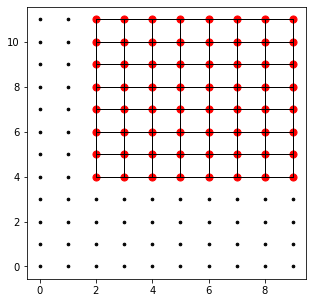

In [129]:
# compact(True, 1)
# compact(False, 1)
print_graph(n, gg)